In [1]:
import math
import inflection
import datetime
import random
import warnings
import pickle
import json
import requests
        
import numpy             as np
import pandas            as pd
import seaborn           as sns
import xgboost           as xgb
import matplotlib.pyplot as plt

from IPython.core.display  import HTML
from IPython.display       import Image
from scipy                 import stats as ss
from tabulate              import tabulate
from boruta                import BorutaPy

from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    sns.set_style('whitegrid')
    
def cramer_v(x,y):    
    cm = pd.crosstab(x, y).values                     # confusion matrix
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]                 # from pearson chi-squared test
    chi2_corr = max(0, chi2 - ((k-1)*(r-1) / (n-1)))
    
    k_corr = k - ((k-1)**2 / (n-1))
    r_corr = r - ((r-1)**2 / (n-1))
    
    return np.sqrt((chi2_corr/n) / min(k_corr-1, r_corr-1))          # cramer v

# when the course was recorded there was no mean_absolute_percentage_error function on sklearn
def mean_absolute_perc_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

def mean_perc_error(y, yhat):
    return np.mean((y - yhat) / y)

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_perc_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

def cross_val(x_training, kfold, model_name, model, verbose=False):

    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
            
        # defining validation periods
        validation_date_start = x_training['date'].max() - datetime.timedelta(days=k*6*7)  # 6 weeks * 7 days
        validation_date_end = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)  # 6 weeks * 7 days

        # filtering dataset
        training = x_training[x_training['date'] < validation_date_start]
        validation = x_training[(x_training['date'] >= validation_date_start) & (x_training['date'] <= validation_date_end)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store perfomance of each iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),     
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])

In [3]:
jupyter_settings();

Populating the interactive namespace from numpy and matplotlib


C:\Users\debor\anaconda3\envs\DScourseEnv\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [4]:
df_sales_raw = pd.read_csv('../data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# <font color='blue'> Rossmann Sales Prediction </font>

# Summary

1. Context
2. Challenge
3. Solution Development
4. Proof & Conclusion
5. Next Steps

# <font color='blue'> 1. Context </font>

- Monthly reunion for discussing results
- CFO asked for a sales prediction by store for the next 6 weeks

# <font color='blue'> 2. Challenge </font>

# Problem
- Define a budget for improving each store

# Causes
- The current sales prediction presents a high error when comparing to the real sales
- The prediction process is based on personal experience
- The prediction is done manually for the 1115 Rossmann stores
- The prediction display is only available for computer

# Solution
- Sales prediction by store using Machine Learning algorithms
- The visualization of the sales prediction can be accessed via smartphone

# <font color='blue'> 3. Solution Development </font>

# Data Description

In [5]:
df1 = df_raw.copy()

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

In [7]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


In [8]:
df1['date'] = pd.to_datetime(df1['date'])

In [9]:
# competition_distance: distance in meters to the nearest competitor store
# solved based on assumption: if there is no distance info for the nearest competitor, maybe there is no competitor store
# in the first place. To fill the NA info, we can insert a much higher value than the maximum distance in the dataset.

df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month: gives the approximate month of the nearest competitor was opened
# based on assumption: apply current date if null
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year: gives the approximate year of the nearest competitor was opened
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
                 
# promo2_since_week: describes the calendar week when the store started participating in Promo2
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew.
# e.g. 'feb, may, aug, nov' means each round starts in february, may, august, november of any given year for that store
# split the string in a list, and check if the any month coincides with the date to activate the promo2
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [10]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

# Descriptive Statistics

In [11]:
num_attributes = df1.select_dtypes(include=['int64', 'int32', 'float64'])

cat_attributes = df1.select_dtypes(exclude=['int64', 'int32', 'float64', 'datetime64[ns]'])

In [12]:
# Central tendency: mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate results
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes','min', 'max', 'range', 'avg', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,avg,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [13]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

# 2.0. STEP 02 - FEATURE ENGINEERING

In [14]:
df2 = df1.copy()

# Hypothesis Mind Map

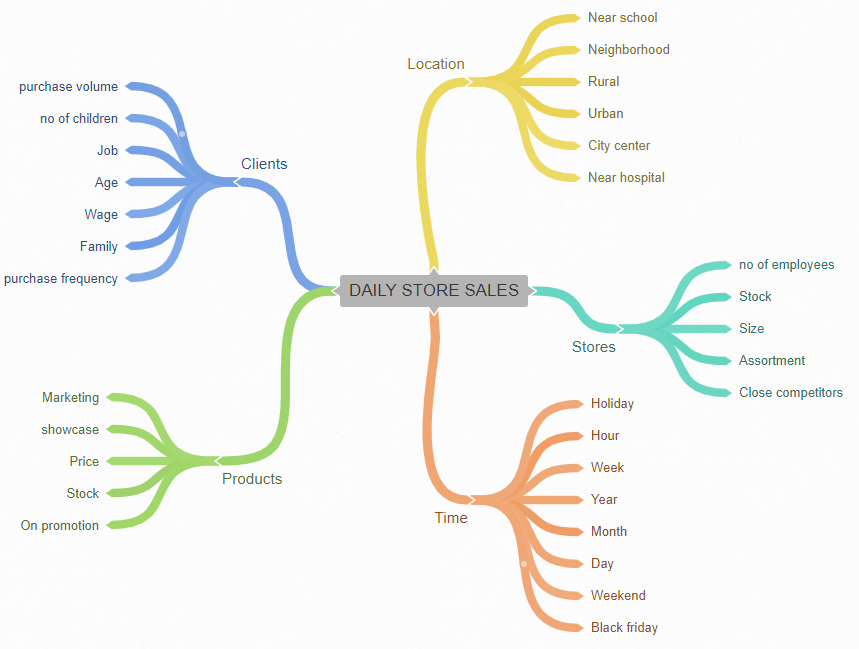

In [15]:
Image('../img/MindMapHypothesis.png')

# Hypothesis for Exploratory Data Analysis

<font size="5">
    
**1.** Stores with higher assortment should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with competitors for a longer period of time should sell more.

**4.** Stores with active promotions for a longer time should sell more.

**5.** Stores with more promotion days should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores open during Christmas should sell more.

**8.** Stores should sell more along the years.

**9.** Stores should sell more in the second semester of the year.

**10.** Stores should sell more after the 10th day of each month.

**11.** Stores should sell less during weekends.

**12.** Stores should sell less during schoold holidays.

</font>

## 2.4. Feature Engineering

In [16]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)

df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)     # how long there is a competitor nearby in months


# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)      # how long a promotion is active in weeks


# assortment: a - basic, b - extra, c - extended
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday: a = public holiday, b = Easter holiday, c = Christmas, 0 = None
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a'
                                                 else 'easter_holiday' if x == 'b'
                                                 else 'christmas' if x == 'c'
                                                 else 'regular_day')

# 3.0. STEP 03 - DATA FILTERING

In [17]:
df3 = df2.copy()

In [18]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

In [19]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop(cols_drop, axis=1)

# EXPLORATORY DATA ANALYSIS

In [20]:
df4 = df3.copy()

# Response Variable

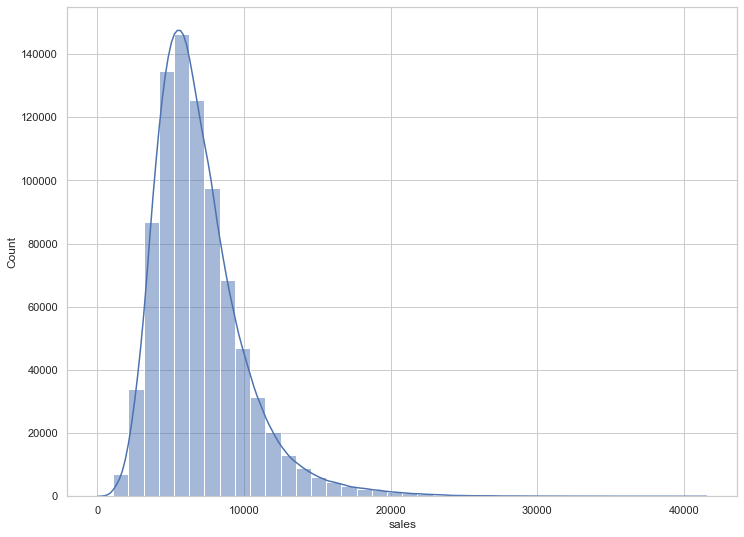

In [21]:
plt.figure(figsize=(12,9))
sns.histplot(df4['sales'], bins=40, kde=True);

# Numerical Variables

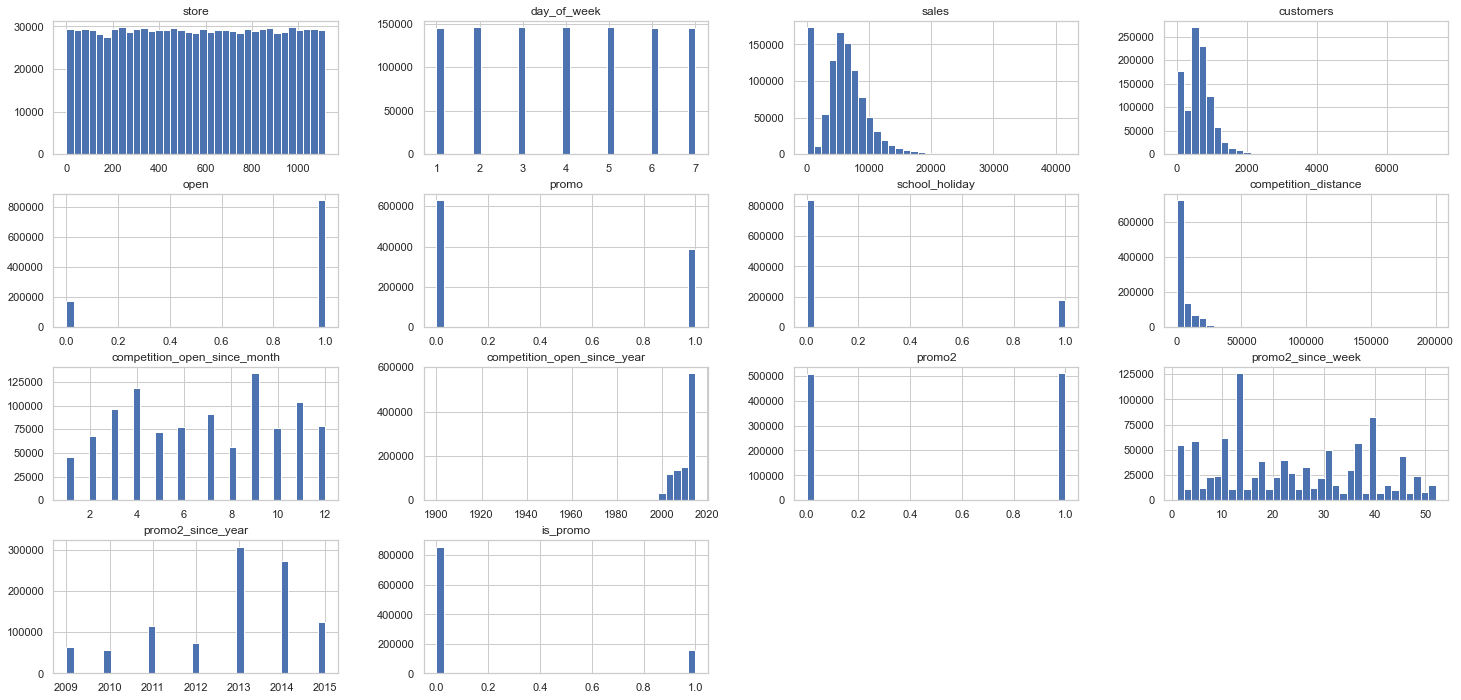

In [22]:
num_attributes.hist(bins=35);

# Categorical Variables

In [23]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

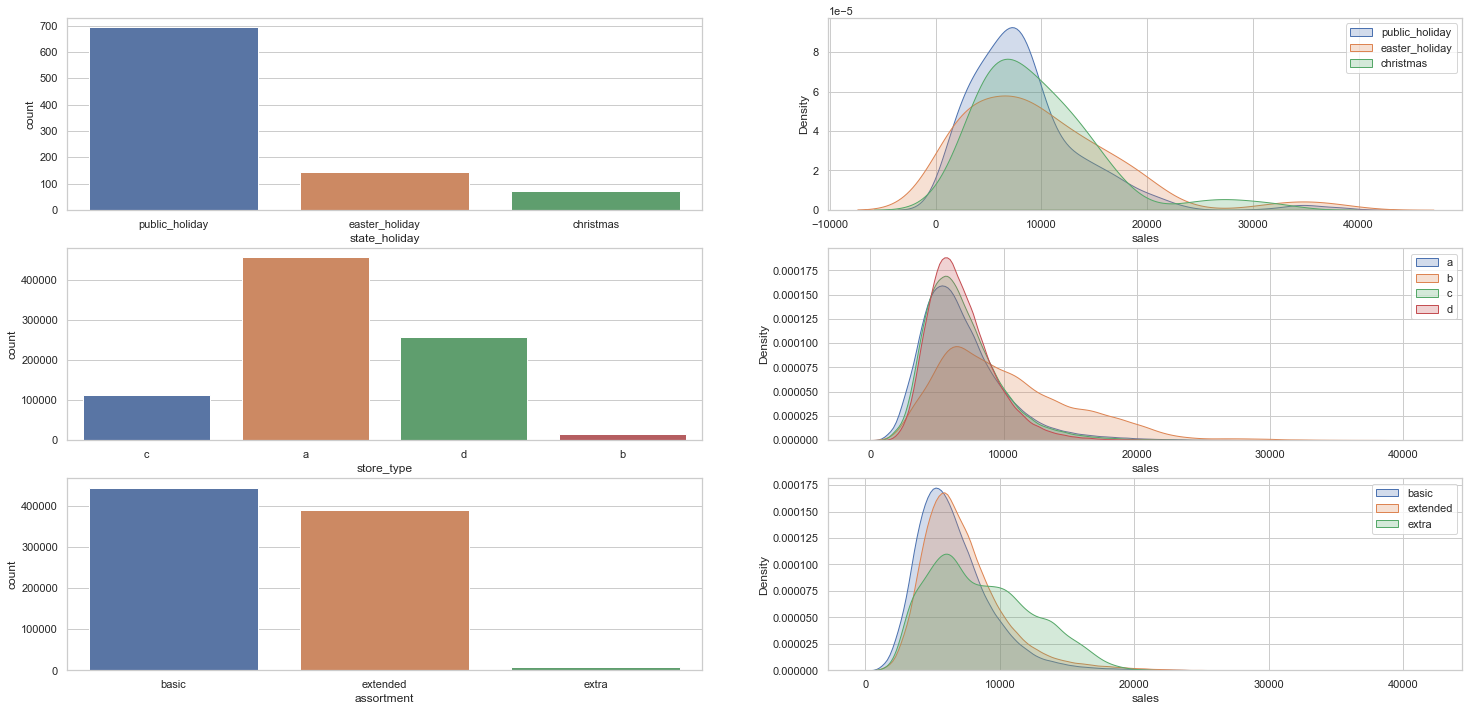

In [24]:
# state holiday
a = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(3,2,1)
sns.countplot(x='state_holiday', data=a)

plt.subplot(3,2,2)
# sns.kdeplot(x='sales', data=df4[df4['state_holiday'] != 'regular_day'], hue='state_holiday', shade=True)      # this density is refering to the dataframe df4[df4['state_holiday'] != 'regular_day']

# this approach consideres a different density function for each dataframe df4[df4['state_holiday'] == ... ]
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)
plt.legend()

# store type
plt.subplot(3,2,3)
sns.countplot(x='store_type', data=df4)

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)
plt.legend()

# assortment
plt.subplot(3,2,5)
sns.countplot(x='assortment', data=df4)

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)
plt.legend();

# Hypothesis validation

### **H1.** Stores with higher assortment should sell more.

**False** Stores with SMALLER assortment sell LESS.

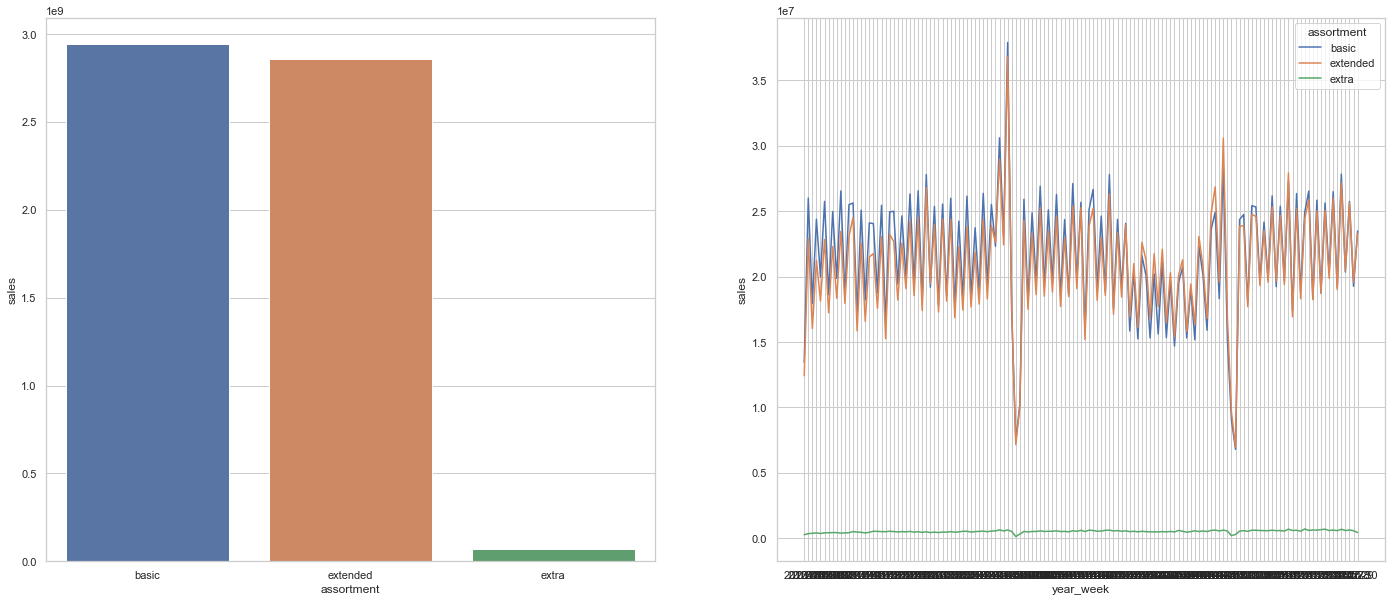

In [25]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()

plt.figure(figsize=(24,10))

plt.subplot(1,2,1)
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment','sales']].groupby(['year_week', 'assortment']).sum().reset_index()
plt.subplot(1,2,2)
sns.lineplot(x='year_week', y='sales', hue='assortment', data=aux2);

### **H2.** Stores with closer competitors should sell less.
**False** Stores with CLOSER competitors sell MORE.

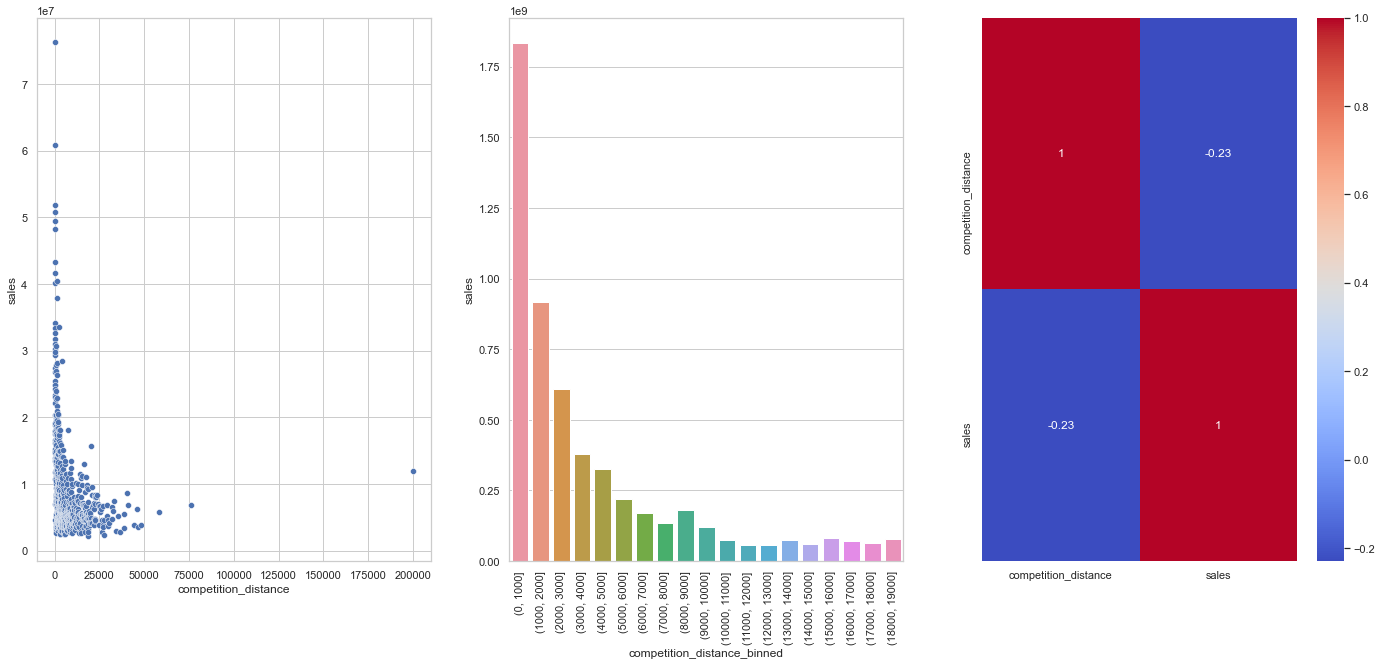

In [56]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.figure(figsize=(24,10))
plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1,3,2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='coolwarm');

### **H4.** Stores with active promotions for a longer time should sell more.
**False** Stores with ACTIVE PROMOTIONS for longer SELL LESS, after a given period of time.

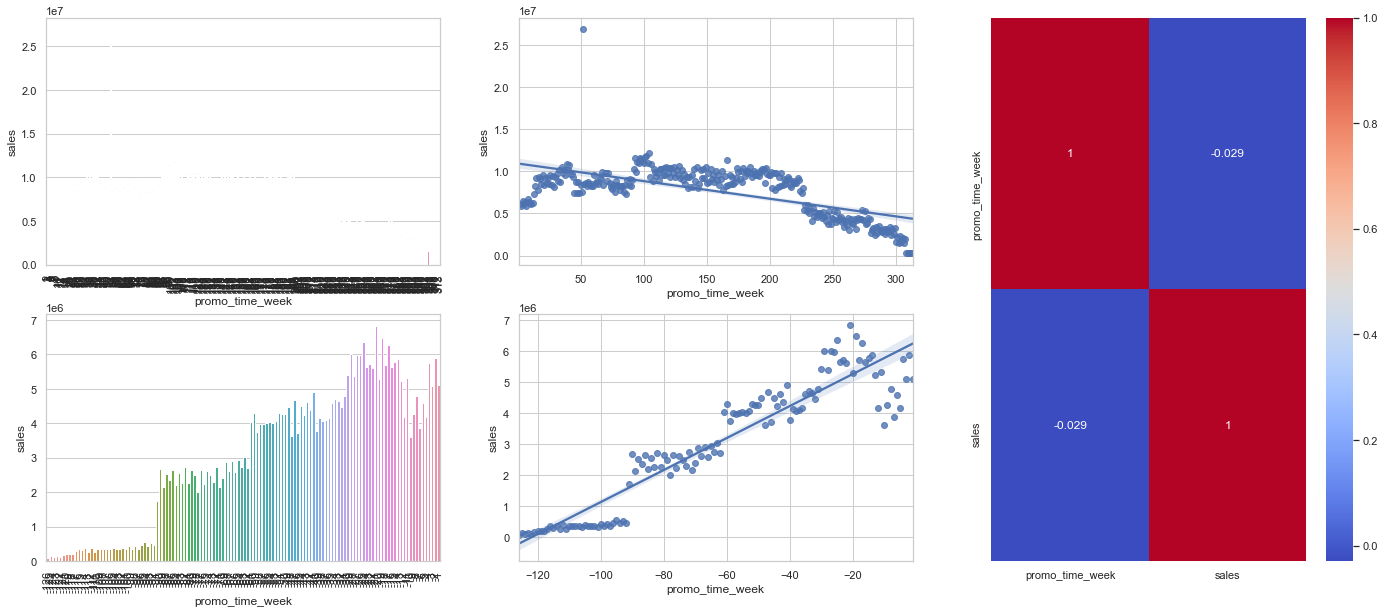

In [55]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.figure(figsize=(24,10))
plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0]  # extended promo
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0]  # regular promo
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='coolwarm');

### **H6.** Stores with more consecutive promotions should sell more.
**False** Stores with MORE consecutive promotions SELL LESS.

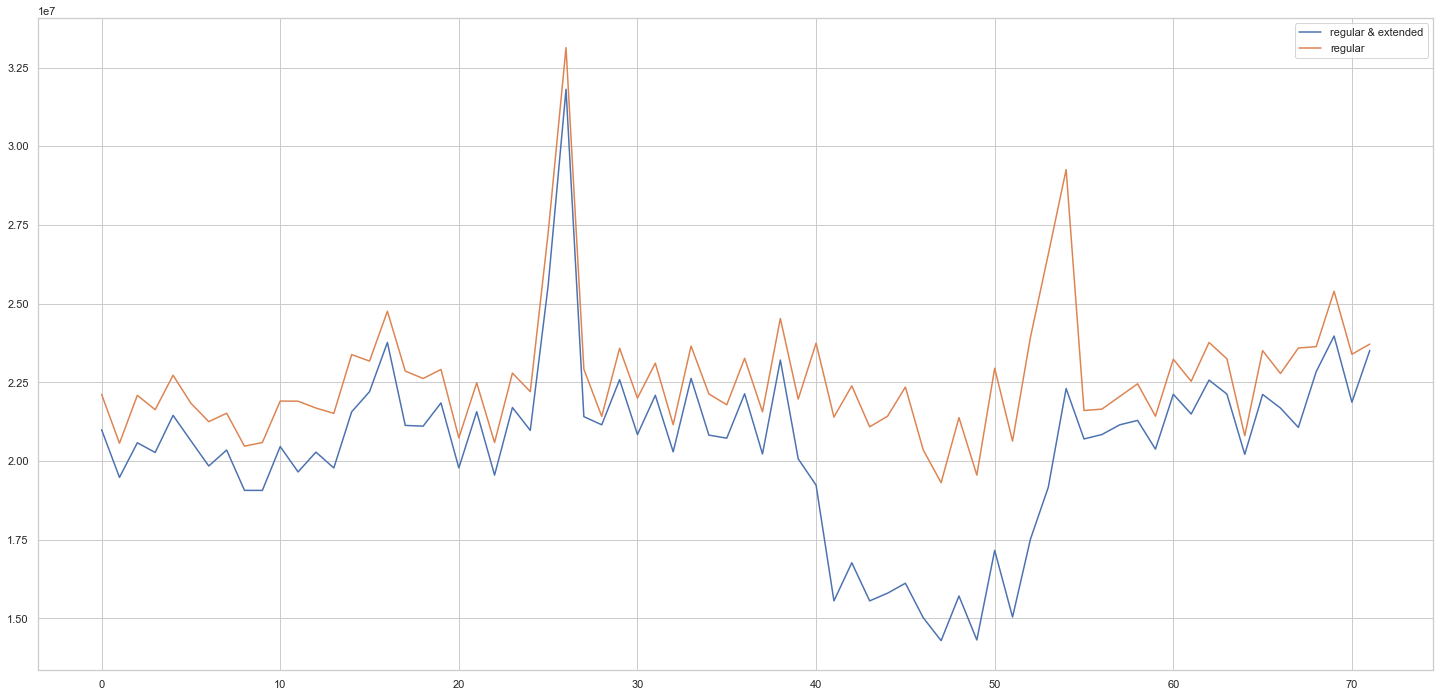

In [53]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['regular & extended','regular']);

# Summary of the hypothesis

In [29]:
tab = [['Hypothesis', 'Conclusion', 'Relevance'],
       ['H1', 'False', 'Low'],
       ['H2', 'False', 'Medium'],
       ['H3', 'False', 'Medium'],
       ['H4', 'False', 'Low'],
       ['H5', '-', '-'],
       ['H6', 'False', 'Low'],
       ['H7', 'False', 'Medium'],
       ['H8', 'False', 'High'],
       ['H9', 'False', 'High'],
       ['H10', 'True', 'High'],
       ['H11', 'True', 'High'],
       ['H12', 'True', 'Low']]

print(tabulate(tab, headers='firstrow'))

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            -             -
H6            False         Low
H7            False         Medium
H8            False         High
H9            False         High
H10           True          High
H11           True          High
H12           True          Low


# Multivariate Analysis

# Numerical Attributes

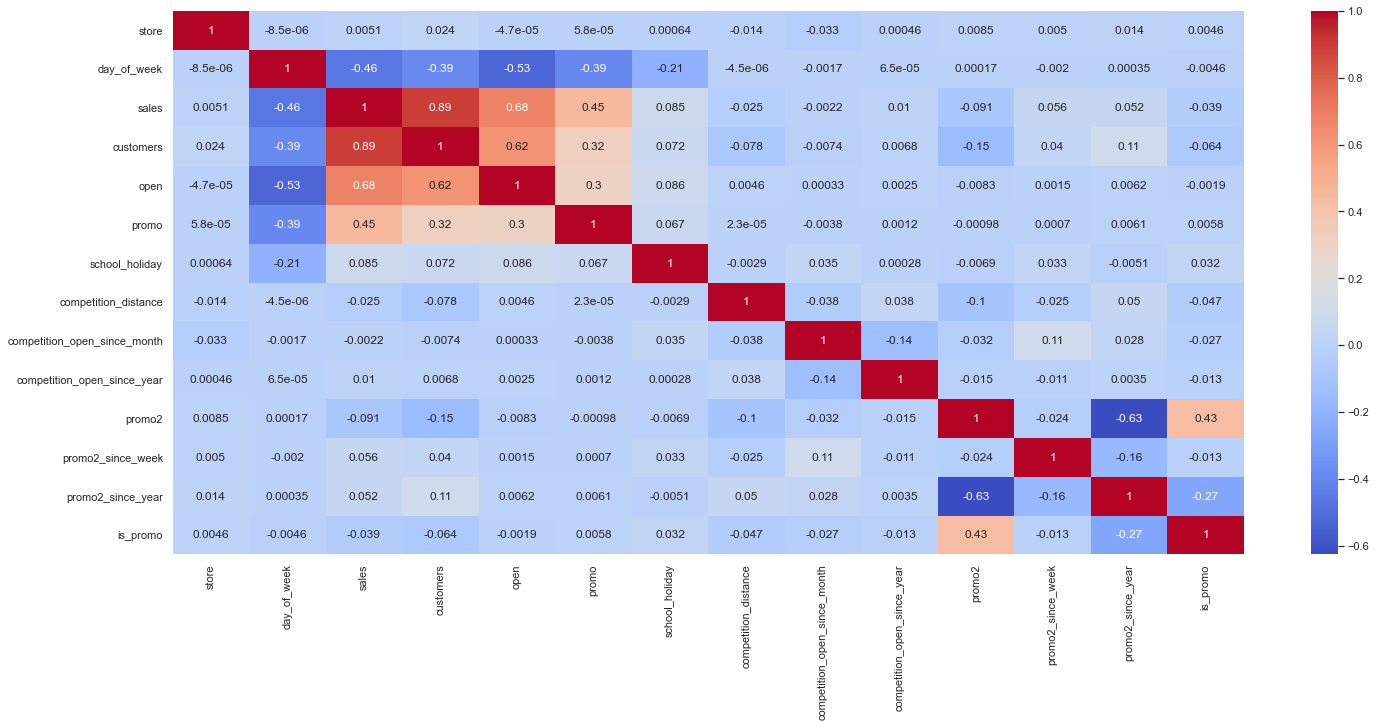

In [30]:
num_corr = num_attributes.corr(method='pearson')

plt.figure(figsize=(24,10))
sns.heatmap(num_corr, annot=True, cmap='coolwarm');

# Categorical Attributes

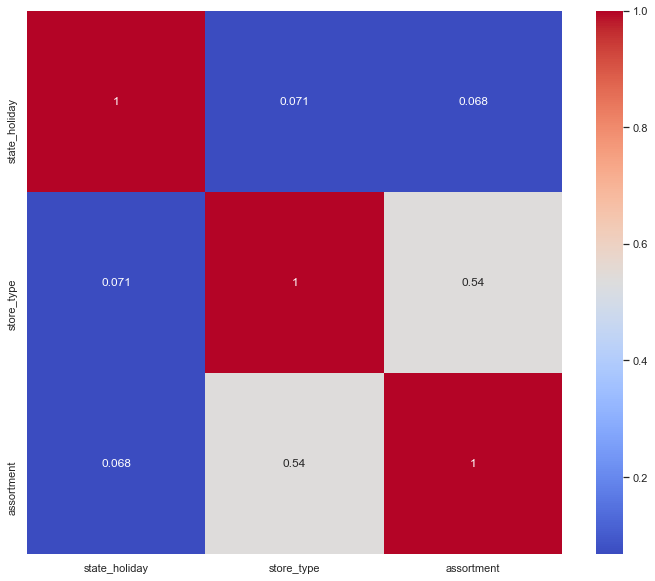

In [31]:
# Only categorical Data
a = df4.select_dtypes(include='object')

# Apply cramer_v function to correlate variables
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# correlation matrix
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)

# plot
plt.figure(figsize=(12,10))
sns.heatmap(d, annot=True, cmap='coolwarm');

# 5.0. STEP 05 - DATA PREPARATION

In [32]:
df5 = df4.copy()

## 5.2 Rescalling

In [33]:
a = df5.select_dtypes(include = ['int32', 'int64', 'float64', 'UInt32'])

In [34]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance -> strong outlier
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
# pickle.dump(rs, open('/Users/debor/repos/DS-Community-Course/parameter/competition_distance_scaler.pkl', 'wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
# pickle.dump(rs, open('/Users/debor/repos/DS-Community-Course/parameter/competition_time_month_scaler.pkl', 'wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
# pickle.dump(mms, open('/Users/debor/repos/DS-Community-Course/parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
# pickle.dump(mms, open('/Users/debor/repos/DS-Community-Course/parameter/year_scaler.pkl', 'wb'))

## 5.3 Transformation

### 5.3.1 Encoding

In [35]:
# state_holiday - One hot encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
# pickle.dump(le, open('/Users/debor/repos/DS-Community-Course/parameter/store_type_scaler.pkl', 'wb'))

# assortment - ordinal encoding
assortment_dict = {'basic': 1, 'extended': 2, 'extra': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Response Variable Transformation

In [36]:
# response variable log transformation
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3. Nature Transformation

In [37]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))


# 6.0. STEP 06 - FEATURE SELECTION

In [38]:
df6 = df5.copy()

## 6.1. Split Dataset into training and test data

In [39]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']

df6 = df6.drop(cols_drop, axis=1)

In [40]:
# training data
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test data
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

## 6.3. Manual Feature Selection

In [41]:
# manually added month_sin, week_of_year_sin
cols_selected_boruta = ['store', 
                        'promo', 
                        'store_type', 
                        'assortment', 
                        'competition_distance',
                        'competition_open_since_month', 
                        'competition_open_since_year', 
                        'promo2',
                        'promo2_since_week', 
                        'promo2_since_year', 
                        'competition_time_month',
                        'promo_time_week', 
                        'day_of_week_sin', 
                        'day_of_week_cos', 
                        'month_cos',
                        'month_sin',
                        'day_sin', 
                        'day_cos', 
                        'week_of_year_cos',
                        'week_of_year_sin']

cols_not_selected_boruta = ['is_promo', 
                            'month_sin', 
                            'school_holiday',
                            'state_holiday_christmas', 
                            'state_holiday_easter_holiday',
                            'state_holiday_public_holiday', 
                            'state_holiday_regular_day',
                            'week_of_year_sin', 
                            'year']

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0. STEP 07 - MACHINE LEARNING MODELLING

In [42]:
warnings.filterwarnings('ignore')

df7 = df6.copy()

x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# time series data preparation
x_training = X_train[cols_selected_boruta_full]

# MACHINE LEARNING MODELLING

## Comparing Model's Performance

In [43]:
tab = [['Model Name', 'MAE', 'MAPE', 'RMSE'],
       ['Random Forest Regressor',   '838.51 +/- 219.95', '0.12 +/- 0.02', '1257.95 +/- 320.68'],
       ['XGBoost Regressor',         '1782.97 +/- 215.23', '0.24 +/- 0.01', '2578.56 +/- 299.92'],
       ['Linear Regression',         '2077.72 +/- 295.95', '0.3 +/- 0.02', '2945.54 +/- 469.14'],
       ['Linear Regression - Lasso', '2117.99 +/- 342.74', '0.29 +/- 0.01', '3058.17 +/- 506.07']]

print(tabulate(tab, headers='firstrow'))

Model Name                 MAE                 MAPE           RMSE
-------------------------  ------------------  -------------  ------------------
Random Forest Regressor    838.51 +/- 219.95   0.12 +/- 0.02  1257.95 +/- 320.68
XGBoost Regressor          1782.97 +/- 215.23  0.24 +/- 0.01  2578.56 +/- 299.92
Linear Regression          2077.72 +/- 295.95  0.3 +/- 0.02   2945.54 +/- 469.14
Linear Regression - Lasso  2117.99 +/- 342.74  0.29 +/- 0.01  3058.17 +/- 506.07


# 8.0. STEP 08 - HYPERPARAMETER FINE TUNING

In [44]:
# LOAD MODEL FROM FILE
model_xgb_tuned = pickle.load(open('/Users/debor/repos/DS-Community-Course/model/model_xgb_rossmann.pkl', 'rb'))

# PREDICTION
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# PERFORMANCE
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))

# <font color='blue'> 4. Proof & Conclusion </font>

In [45]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

# TRANSLATE MODEL'S PERFORMANCE

## Business Performance

In [46]:
# Predictions sum
df91 = df9[['store','predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_perc_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')

df92 = pd.merge(df91, df9_aux3, how='inner', on='store')


# Possible scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# Ordering columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [47]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,106526.171875,103142.967851,109909.375899,3383.204024,0.588705
908,909,221231.062500,213394.278894,229067.846106,7836.783606,0.513469
901,902,201629.984375,200178.039049,203081.929701,1451.945326,0.362795
169,170,203802.296875,202400.937467,205203.656283,1401.359408,0.346350
875,876,196134.921875,192090.318476,200179.525274,4044.603399,0.328029


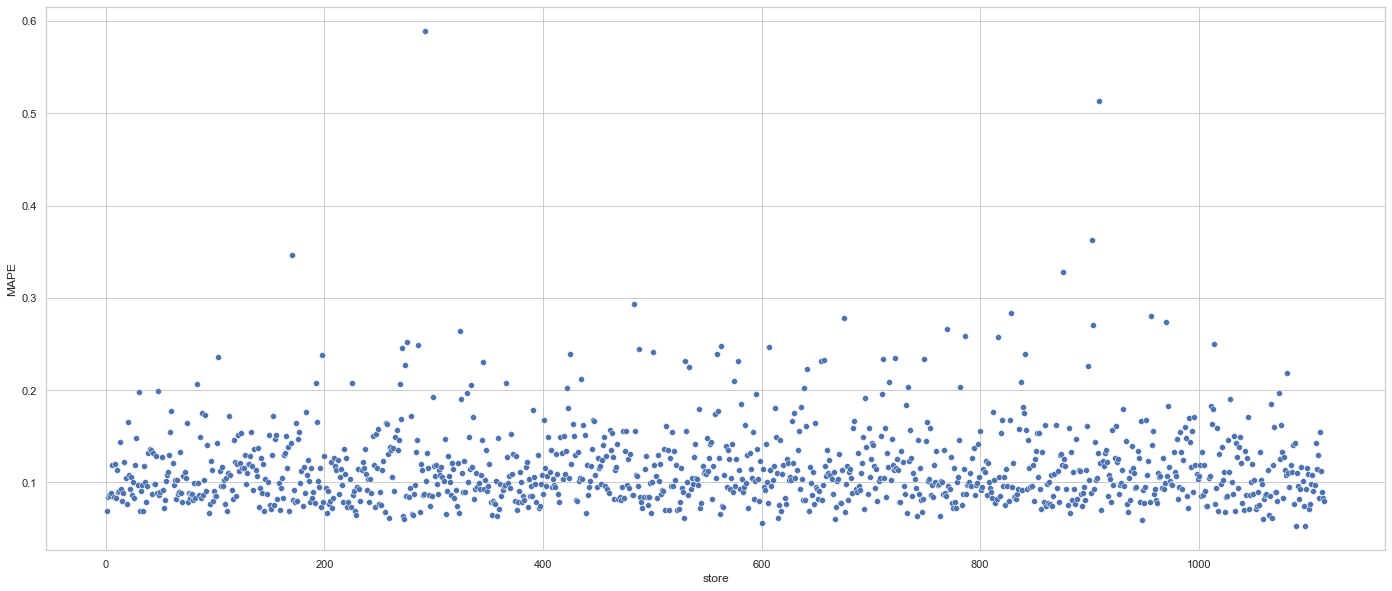

In [48]:
plt.figure(figsize=(24,10))
sns.scatterplot(x='store', y='MAPE', data=df92);

# Total Performance

In [49]:
df93 = df92[['predictions','worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0: 'Values'})

df93['Values'] = df93['Values'].map('{:,.2f} $'.format)

df93

,Scenario,Values
0,predictions,"286,667,584.00 $"
1,worst_scenario,"285,809,935.16 $"
2,best_scenario,"287,525,229.80 $"


# Machine Learning Performance

In [50]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

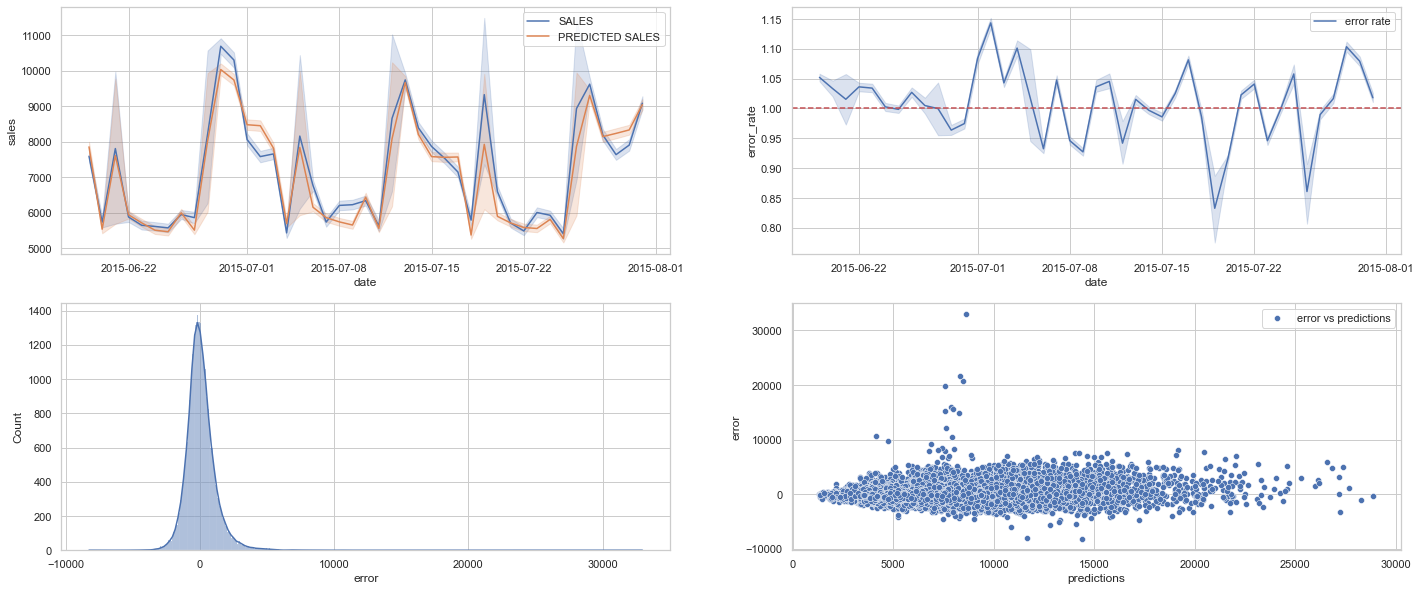

In [51]:
plt.figure(figsize=(24,10))
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES');
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTED SALES');

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9, label='error rate');
plt.axhline(1, linestyle='--', color='r');

plt.subplot(2,2,3)
sns.histplot(df9['error'], kde=True);

plt.subplot(2,2,4)
sns.scatterplot(x='predictions', y='error', data=df9, label='error vs predictions');

# Model usage

In [52]:
HTML("""
    <video alt="test" controls>
        <source src="../img/video.mp4" type="video/mp4">
    </video>
""")

# <font color='blue'> 5. Next Steps </font>

- Short workshop for model utilization for business users
- Collect feedback about the model utilization
- Improve in 10% the model's precision

# <font color='blue'> Q & A </font>

# <font color='blue'> Thank you! </font>